# Using Recurrent Neural Networks to predict physical time evolution

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 6, Tutorial (this is discussed in session 6)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- train a recurrent network (LSTM) to correctly predict a force that can only be predicted based on previous observations

The physical example is a 'heavy' particle immersed in a bath of 'light' particles. We are only allowed to observe the motion of the heavy particle, but we still want to predict the force exerted by the other particles (which are initialized randomly in each run). This can only be done by exploiting memory, using the past observations of the heavy particle's motion.

### Imports: numpy and matplotlib and keras

In [70]:
# keras: Sequential is the neural-network class, Dense is
# the standard network layer
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

In [20]:
def runge_kutta_step(X,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order. Implemented this here
    to avoid dependency on any external package (you can find nice
    implementations in scipy, for example)
    """
    k1=rhs(X)
    k2=rhs(X+0.5*dt*k1)
    k3=rhs(X+0.5*dt*k2)
    k4=rhs(X+dt*k3)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

def solve(X0,rhs,T,nsteps):
    """
    Solve the differential equation dX/dt=rhs(X), for 'nsteps' time steps up to time T,
    with initial value X(t=0)=X0.
    
    Here X0 can have any shape as an array, and rhs(X) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    """
    dt=T/nsteps
    X=np.array(X0,dtype='float')
    Xs=np.zeros(np.shape(X0)+(nsteps,)) # to store all the results: add 'nsteps' dimension
    for j in range(nsteps):
        X+=runge_kutta_step(X,rhs,dt)
        Xs[...,j]=X # store result (... means: we don't care how many dimensions there are!)
    ts=dt*(np.array(range(nsteps))+1) # all time points
    return(Xs,ts)


### Simple harmonic oscillator

In [21]:
def one_harmonic_oscillator_rhs(X):
    # assume X[0] is the coordinate x, X[1] is the velocity v
    return( np.array( [
        X[1],     # dx/dt = v
        -X[0]     # dv/dt = -x
    ] ))

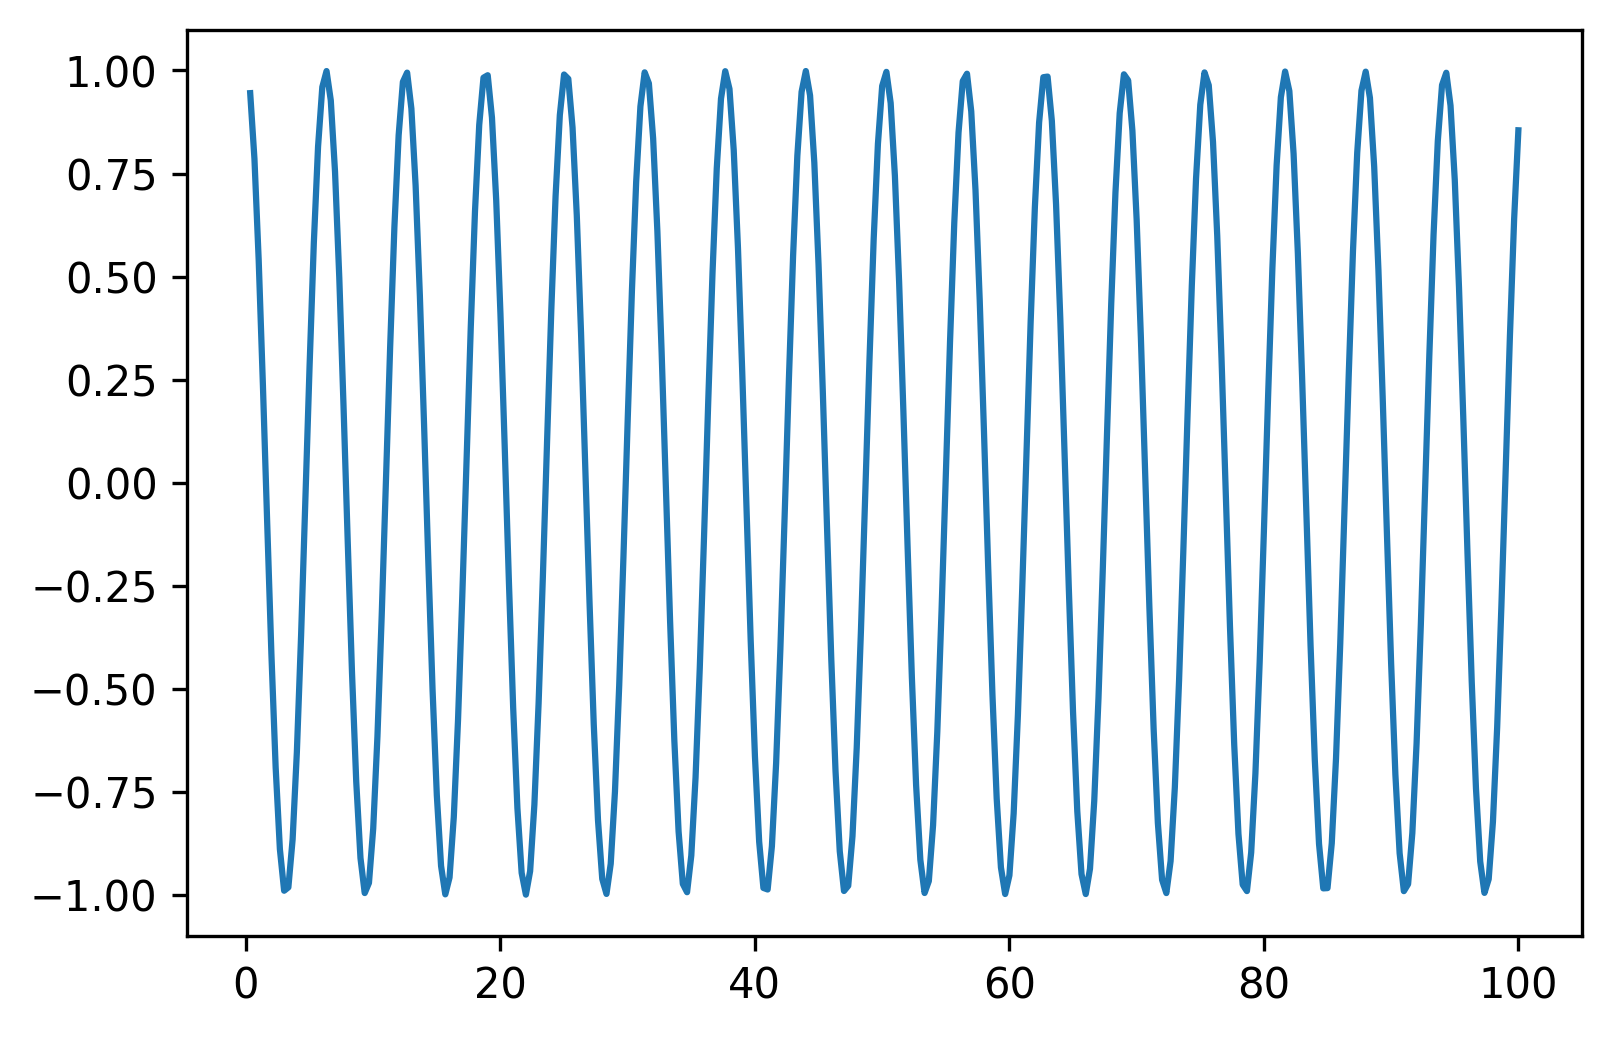

In [39]:
Xs,ts=solve(X0=[1,0],rhs=one_harmonic_oscillator_rhs,T=100.0,nsteps=300)
plt.plot(ts,Xs[0])
plt.show()

### Now: multiple coupled oscillators

Here all the oscillators j=1,2,3,... are coupled to the one special oscillator j=0: 

$$ m_0 {d^2x_0 \over dt^2} = -k_0 x_0 + D \sum_{j>0}(x_j-x_0)$$

and

$$ m_j {d^2x_j \over dt^2} = -k_j x_j + D (x_0-x_j)$$

In [52]:
def multiple_coupled_oscillators_rhs(X):
    # X[0,:] are all the coordinates for all particles (second index)
    # X[1,:] are all the velocities
    global multiple_coupled_oscillators_k # the spring constants for all the oscillators (array)
    global multiple_coupled_oscillators_D # coupling spring constant (coupling all j>1 to j=0)
    global multiple_coupled_oscillators_m # the masses (array)
    
    # all the terms for the oscillators j=1,2,3,... being affected by j=0:
    coupling_acceleration=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m)*(X[0,0]-X[0,:])
    # and now the force acting on j=0, from all the others:
    coupling_acceleration[0]=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m[0])*np.sum(X[0,:]-X[0,0])
    
    return(np.array(
        [
            X[1,:], # dx/dt=v
            -(multiple_coupled_oscillators_k/multiple_coupled_oscillators_m)*X[0,:]+\
            coupling_acceleration # dv/dt=force/mass
        ]
    ))

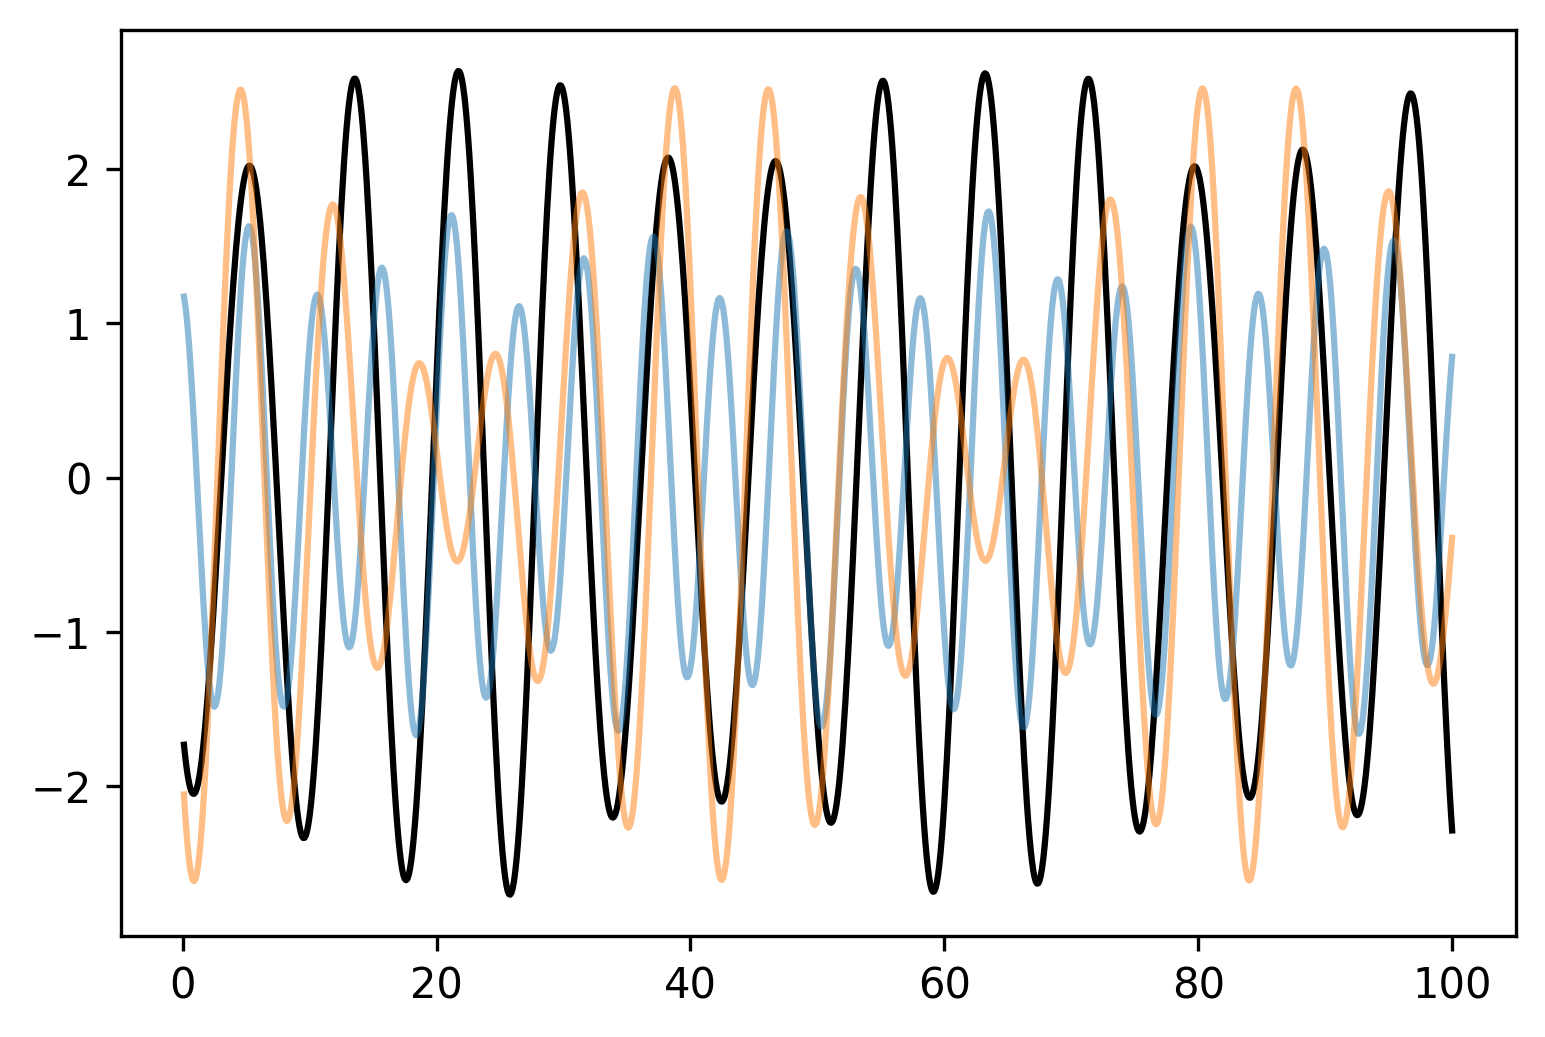

In [53]:
multiple_coupled_oscillators_k=np.array([1.0,1.3,0.7]) # the spring constants
multiple_coupled_oscillators_D=0.1 # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.array([2.0,1.0,1.0]) # the masses

X0=np.random.randn(2,3) # first index: x vs. v / second index: particles
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_rhs,T=100.0,nsteps=1000)
for n in range(3):
    if n==0:
        color="black" # our 'heavy' particle!
        alpha=1
    else:
        color=None
        alpha=0.5
    plt.plot(ts,Xs[0,n],color=color,alpha=alpha)
plt.show()

### Multiple coupled oscillators, batch processing (many trajectories in parallel!)

We simply add a third index to X, which is now an array of shape [2,particle_number,batchsize]. The usual array indexing gymnastics are required to make it work.

In [162]:
def multiple_coupled_oscillators_parallel_rhs(X):
    # X[0,:,:] are all the coordinates for all particles (second index) and all trajectories (third index)
    # X[1,:,:] are all the velocities
    global multiple_coupled_oscillators_k # the spring constants for all the oscillators (array)
    global multiple_coupled_oscillators_D # coupling spring constant (array)
    global multiple_coupled_oscillators_m # the masses (array)
    
    # all the terms for the oscillators j=1,2,3,... being affected by j=0:
    D_over_m=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m)[:,None]
    coupling_acceleration=D_over_m*(X[0,0,:][None,:]-X[0,:,:])
    # and now the force acting on j=0, from all the others:
    D_over_m0=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m[0])[:,None]
    coupling_acceleration[0]=np.sum(D_over_m0*(X[0,:,:]-X[0,0,:][None,:]),axis=0)
    
    return(np.array(
        [
            X[1,:,:], # dx/dt=v
            -(multiple_coupled_oscillators_k/multiple_coupled_oscillators_m)[:,None]*X[0,:,:]+\
            coupling_acceleration # dv/dt=force/mass
        ]
    ))

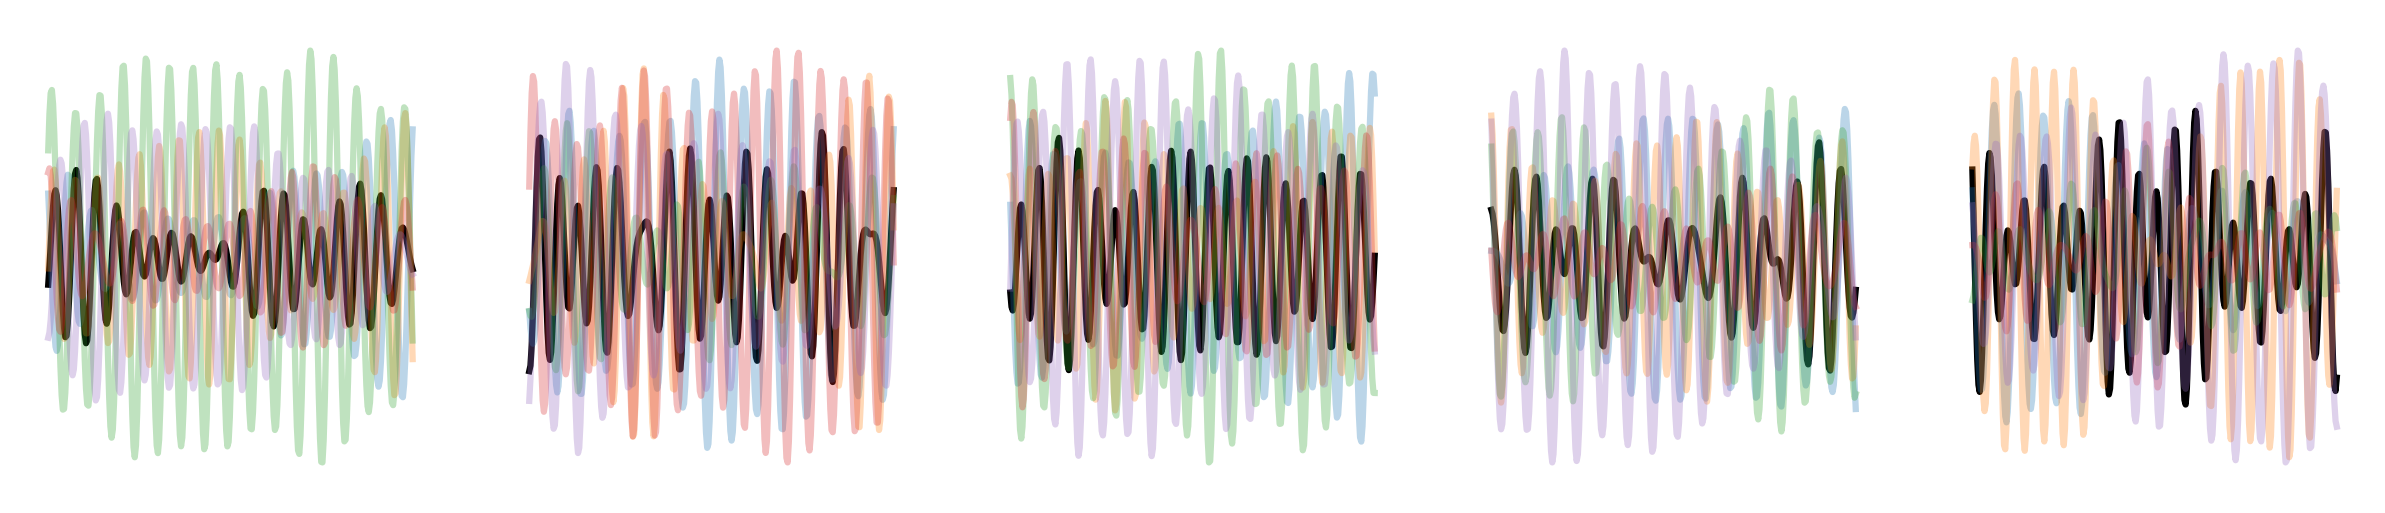

In [69]:
number_particles=6
multiple_coupled_oscillators_k=np.abs( 0.2*np.random.randn(number_particles)+1.0 ) # the spring constants
multiple_coupled_oscillators_D=np.full(number_particles,0.2) # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.abs( 0.2*np.random.randn(number_particles)+1.0 ) # the masses
multiple_coupled_oscillators_m[0]=3.0 # heavy particle
multiple_coupled_oscillators_k[0]=3.0 # hard spring: make it still resonant with the rest!

batchsize=5
X0=np.random.randn(2,number_particles,batchsize) # first index: x vs. v / second index: particles / third: batch
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=100.0,nsteps=300)

fig,ax=plt.subplots(ncols=batchsize,nrows=1,figsize=(batchsize*2,2))
for j in range(batchsize):
    for n in range(number_particles):
        if n==0:
            color="black" # our 'heavy' particle!
            alpha=1
        else:
            color=None
            alpha=0.3
        ax[j].plot(ts,Xs[0,n,j],color=color,alpha=alpha)
        ax[j].axis('off')
plt.show()

Obviously, the heavy particle is strongly influenced by the other particles. 

We will now try to predict the motion of particle 1 based purely on the observations of the heavy particle (number 0)! By observing the full trajectory of the heavy particle, one has to try to infer indirectly what the other particles are up to! This only works with some memory (the current position of particle 0 is not enough).

### Setting up an LSTM network and training it!

In [148]:
Net=Sequential()

Net.add(LSTM(20,input_shape=(None,1),
#             activation="linear",
#             recurrent_activation="linear",
             return_sequences=True)) # LSTM layer with 10 neurons
Net.add(Dense(1,activation="linear"))

Net.compile(loss='mean_squared_error',
              optimizer='adam')


In [102]:
X1=Net.predict_on_batch(Xs[0,0,:,:][:,:,None]) # needs input of shape [batchsize,timesteps,1]

In [103]:
np.shape(X1)

(50, 200, 1)

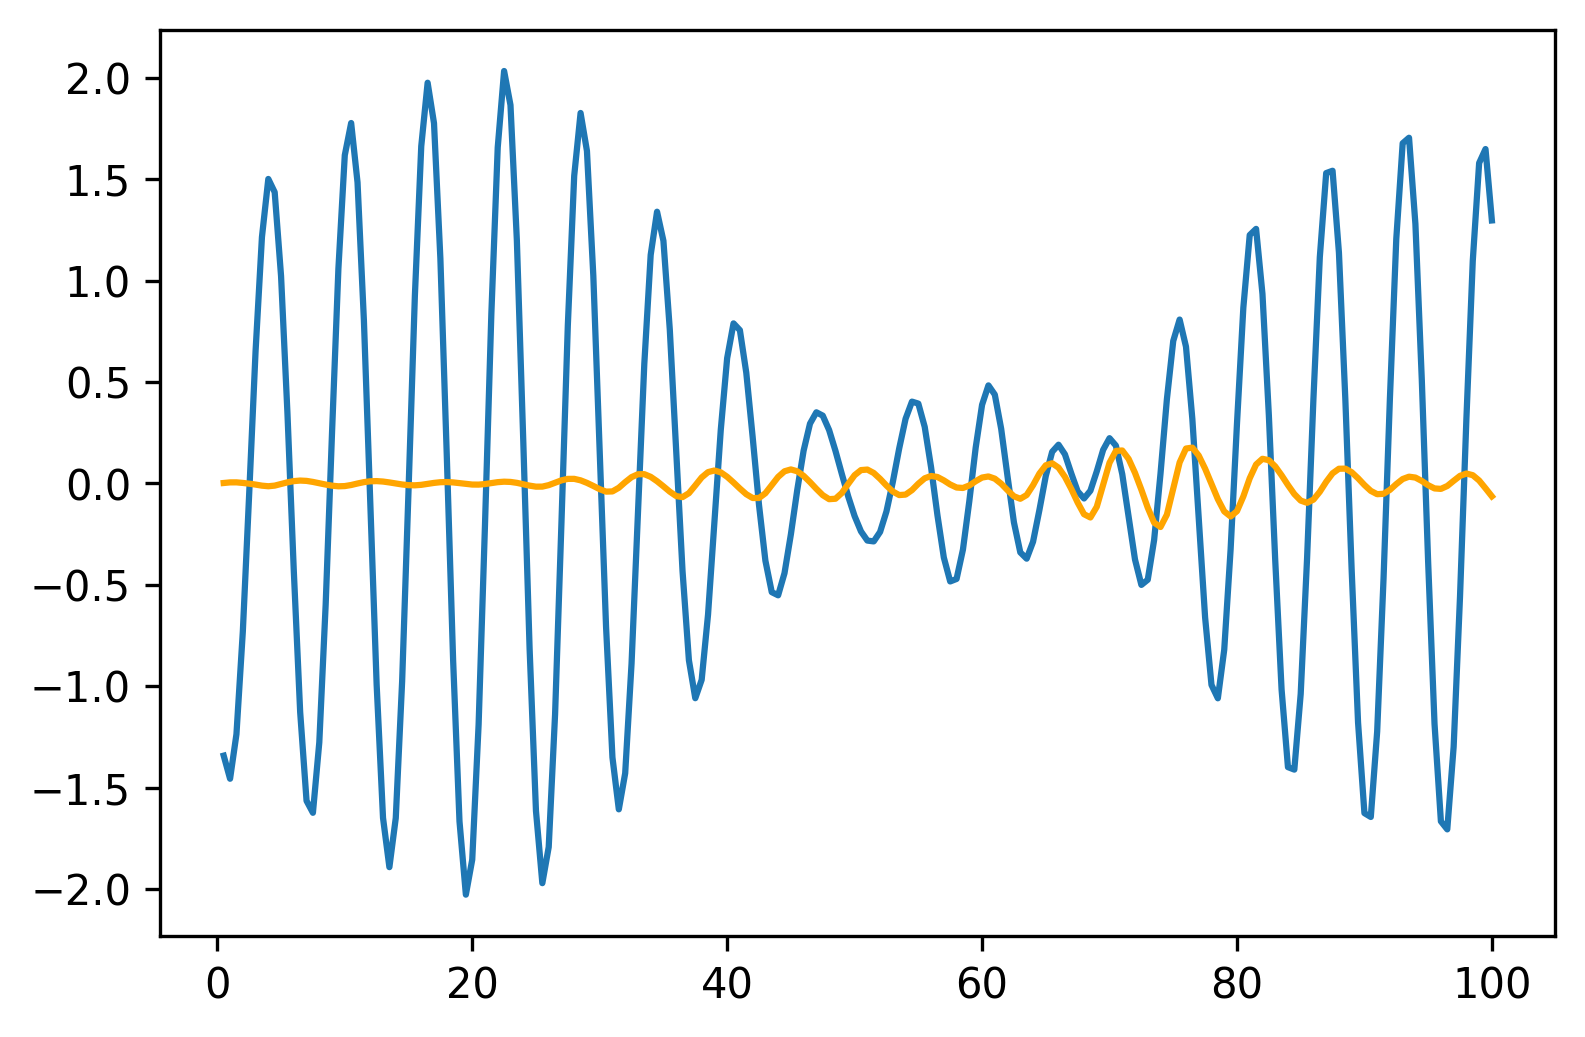

In [104]:
sample=3
plt.plot(ts,Xs[0,1,sample,:])
plt.plot(ts,X1[sample,:,0],color="orange")
plt.show()

In [163]:
number_particles=2
multiple_coupled_oscillators_k=np.array([0.1,0.0]) # the spring constants
multiple_coupled_oscillators_D=np.full(number_particles,0.2) # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.array([2.0,1.0]) # the masses

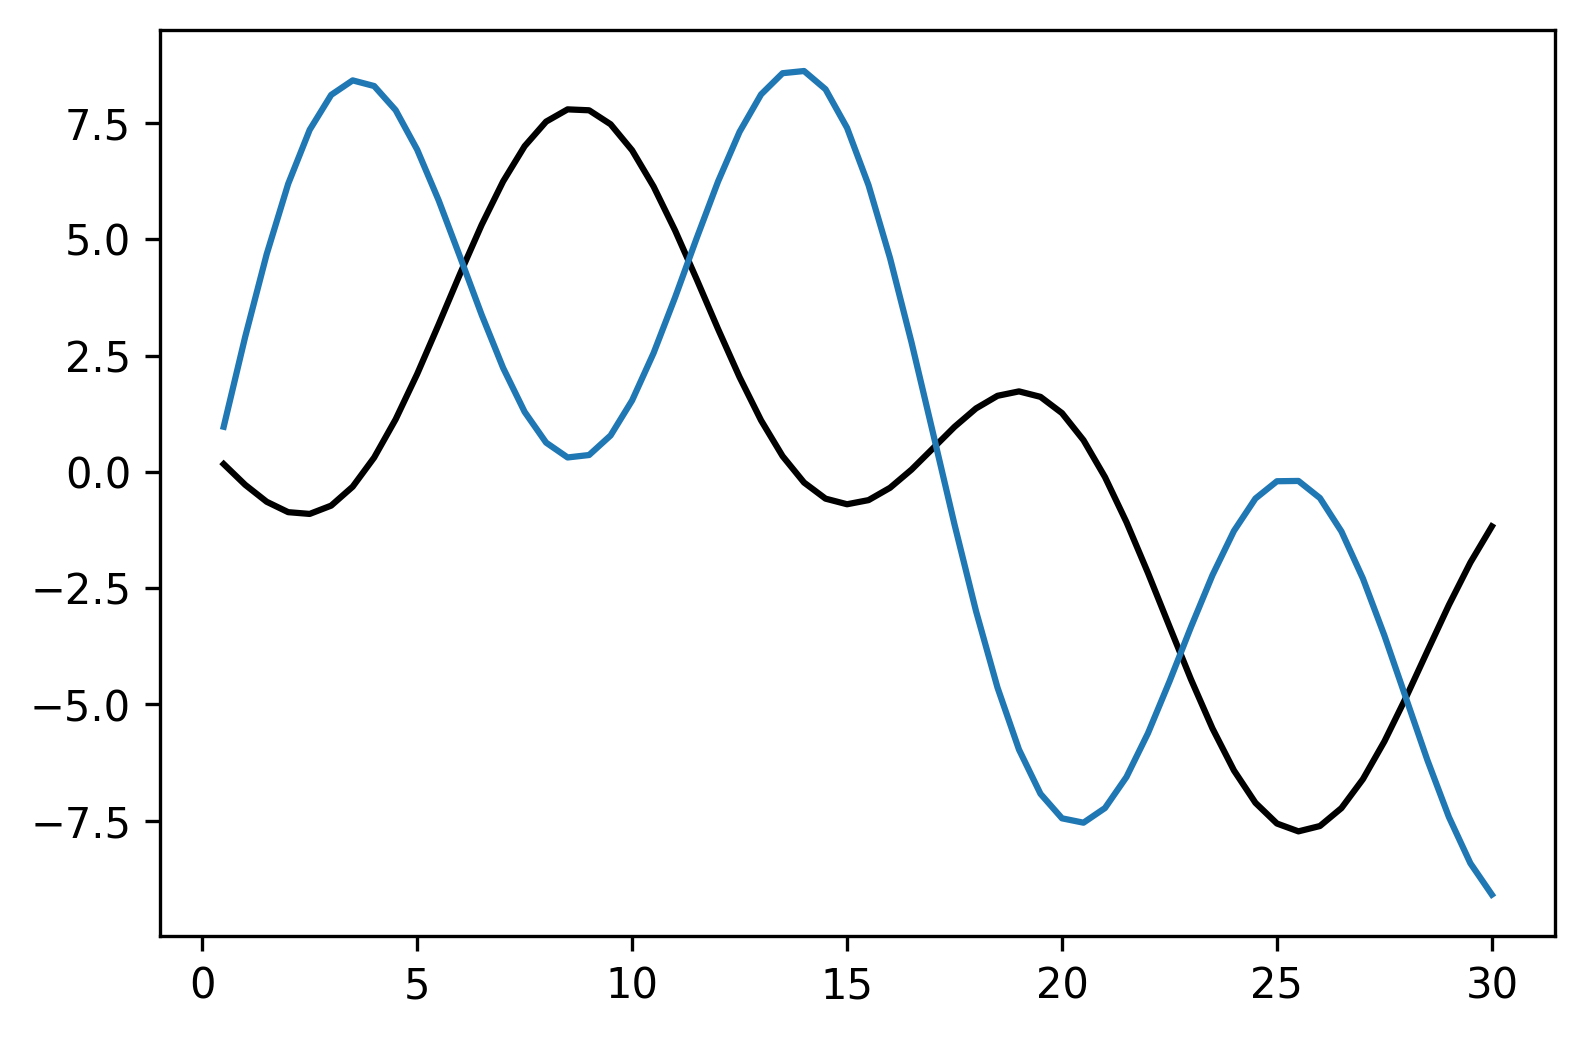

In [164]:
# create one test trajectory
X0=np.random.randn(2,number_particles,1)
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
plt.plot(ts,Xs[0,0,0],color="black")
plt.plot(ts,Xs[0,1,0])
plt.show()


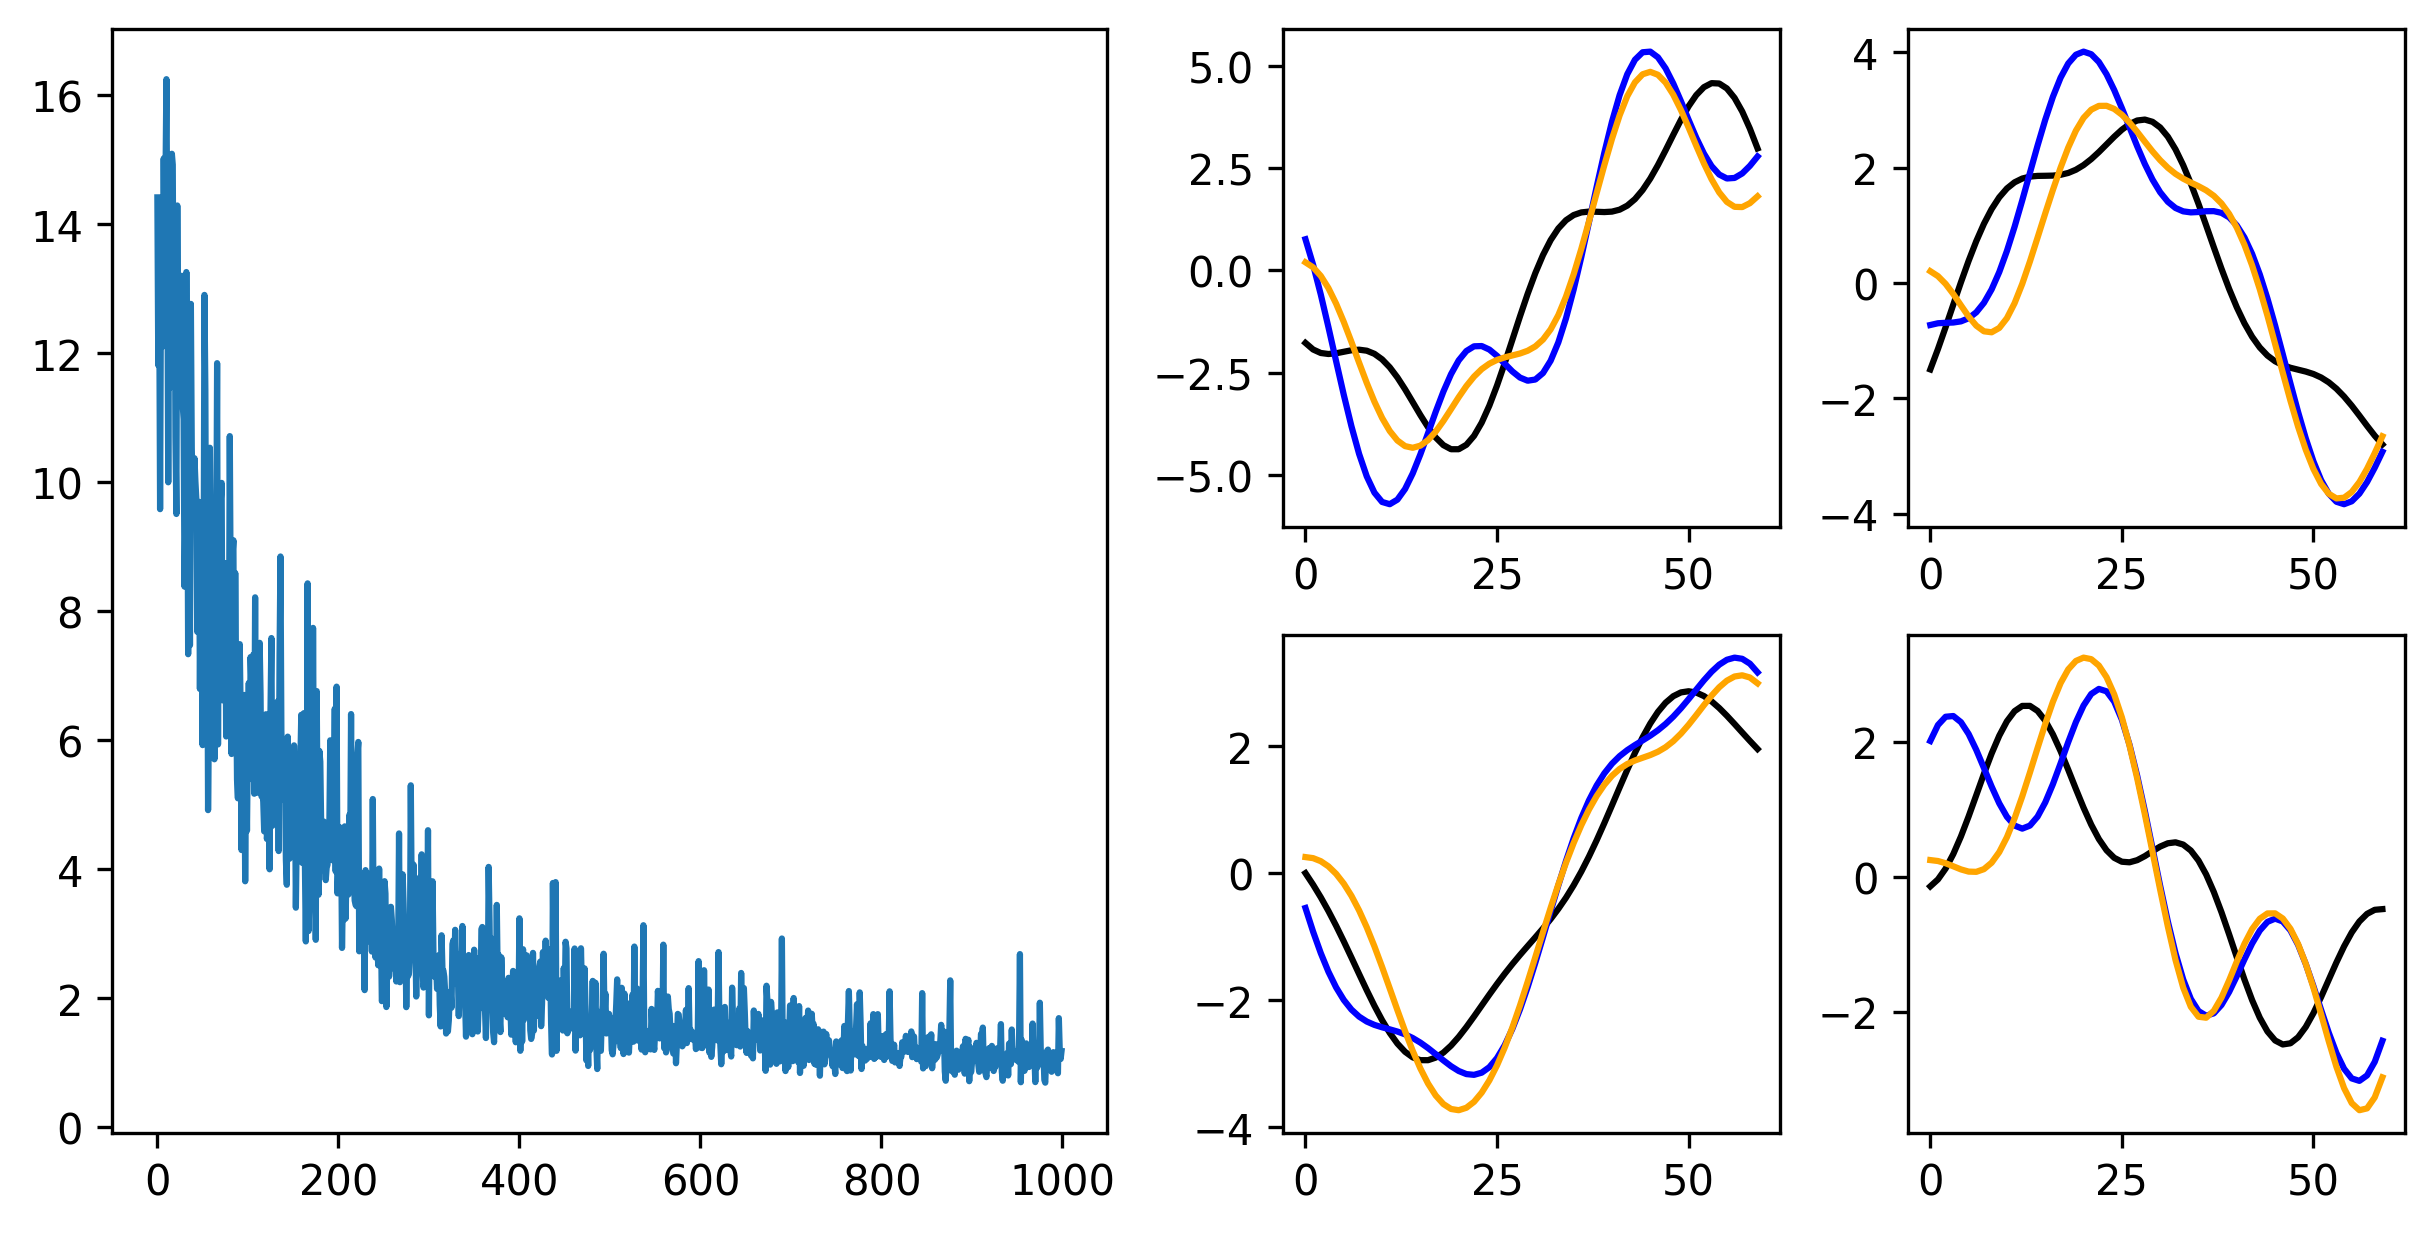

In [151]:
training_steps=1000
batchsize=50
costs=np.zeros(training_steps)

skip_steps=10

# create one test trajectory, to compare against!
X0=np.random.randn(2,number_particles,4)
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
test_input=Xs[0,0,:,:][:,:,None] # will need shape [batchsize,timesteps,1]
test_correct_output=Xs[0,1,:,:][:,:,None] # shape [batchsize,timesteps,1]

for j in range(training_steps):
    X0=np.random.randn(2,number_particles,batchsize)
    Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
    costs[j]=Net.train_on_batch(Xs[0,0,:,:][:,:,None],Xs[0,1,:,:][:,:,None]) 
    # needs input and output of shape [batchsize,timesteps,1]
    if j%skip_steps==0 or j==training_steps-1:
        clear_output(wait=True)
        fig=plt.figure(constrained_layout=True,figsize=(8,4))
        gs=fig.add_gridspec(ncols=4,nrows=2)
        cost_plot=fig.add_subplot(gs[0:2,0:2])
        cost_plot.plot(costs)
        test_output=Net.predict_on_batch(test_input)
        for n in range(4):
            theplot=fig.add_subplot(gs[n%2,2+int(n/2)])
            theplot.plot(test_input[n,:,0],color="black") # particle 0
            theplot.plot(test_correct_output[n,:,0],color="blue") # particle 1
            theplot.plot(test_output[n,:,0],color="orange") # NN-predicted particle 1
        plt.show()
    if False:
        if j%skip_steps==0:
            print(j, ":", costs[j],end="       \r")

In [165]:
number_particles=3
multiple_coupled_oscillators_k=np.array([0.1,0.0,0.3]) # the spring constants
multiple_coupled_oscillators_D=np.array([0.0,0.1,1.0]) # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.array([2.0,1.0,1.0]) # the masses


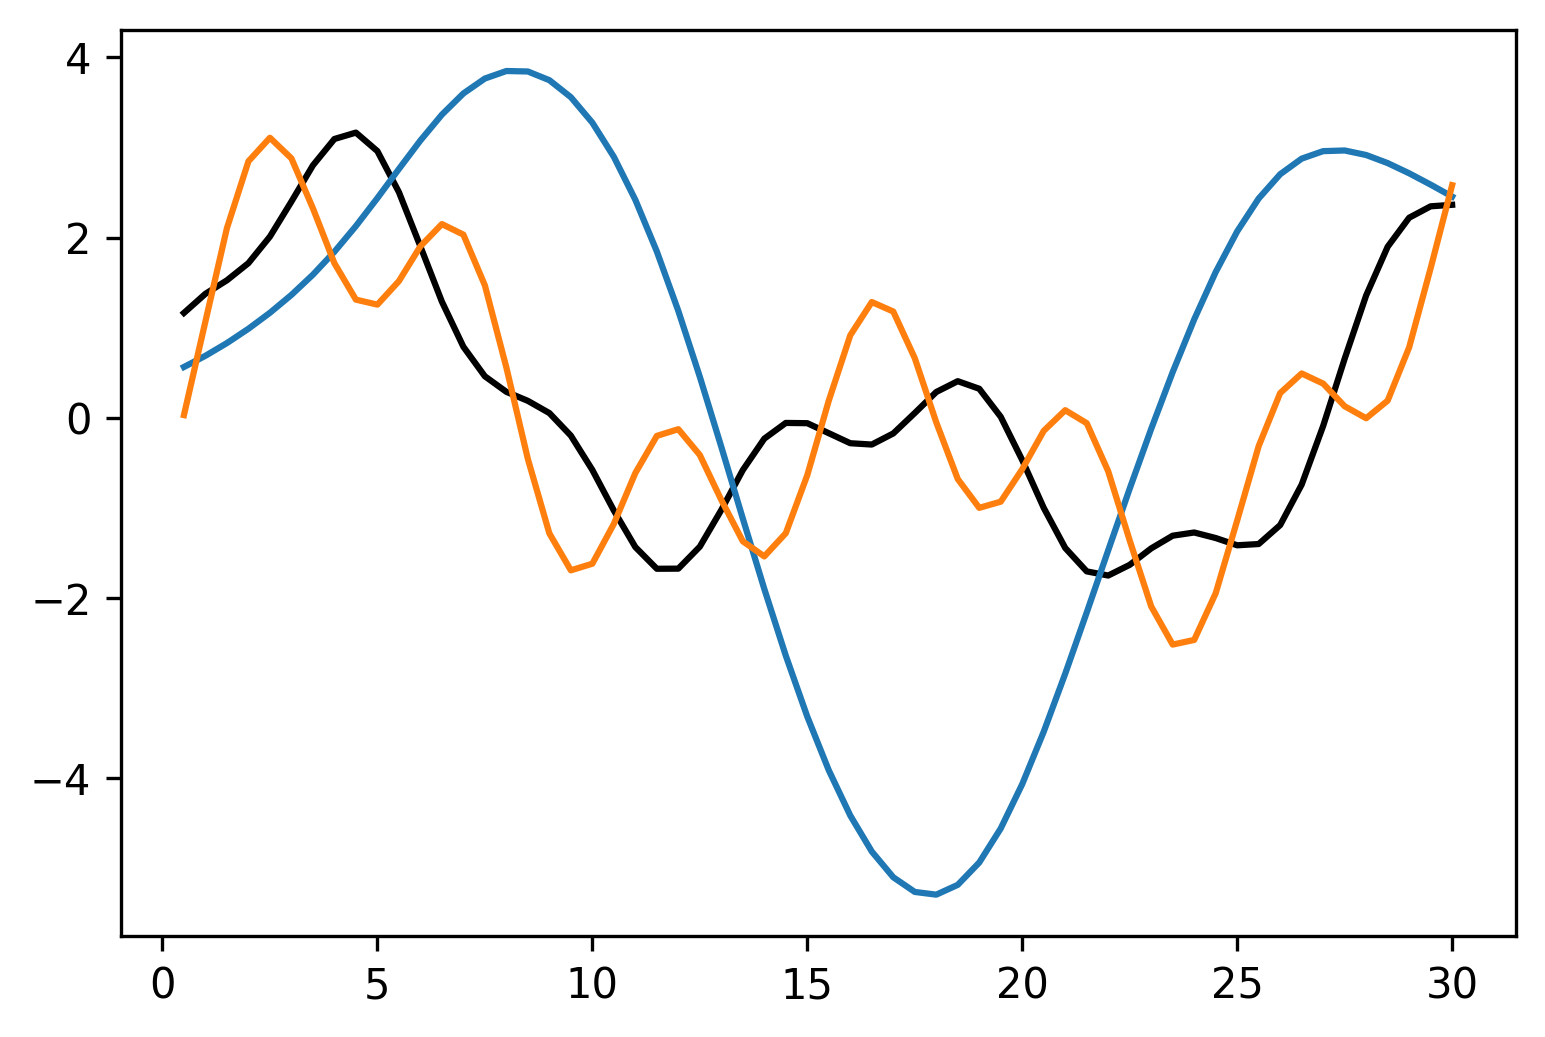

In [167]:
# create one test trajectory
X0=np.random.randn(2,number_particles,1)
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
plt.plot(ts,Xs[0,0,0],color="black")
plt.plot(ts,Xs[0,1,0])
plt.plot(ts,Xs[0,2,0])
plt.show()

In [169]:
Net=Sequential()

Net.add(LSTM(20,input_shape=(None,1),
             return_sequences=True)) # LSTM layer with 10 neurons
Net.add(Dense(1,activation="linear"))

Net.compile(loss='mean_squared_error',
              optimizer='adam')


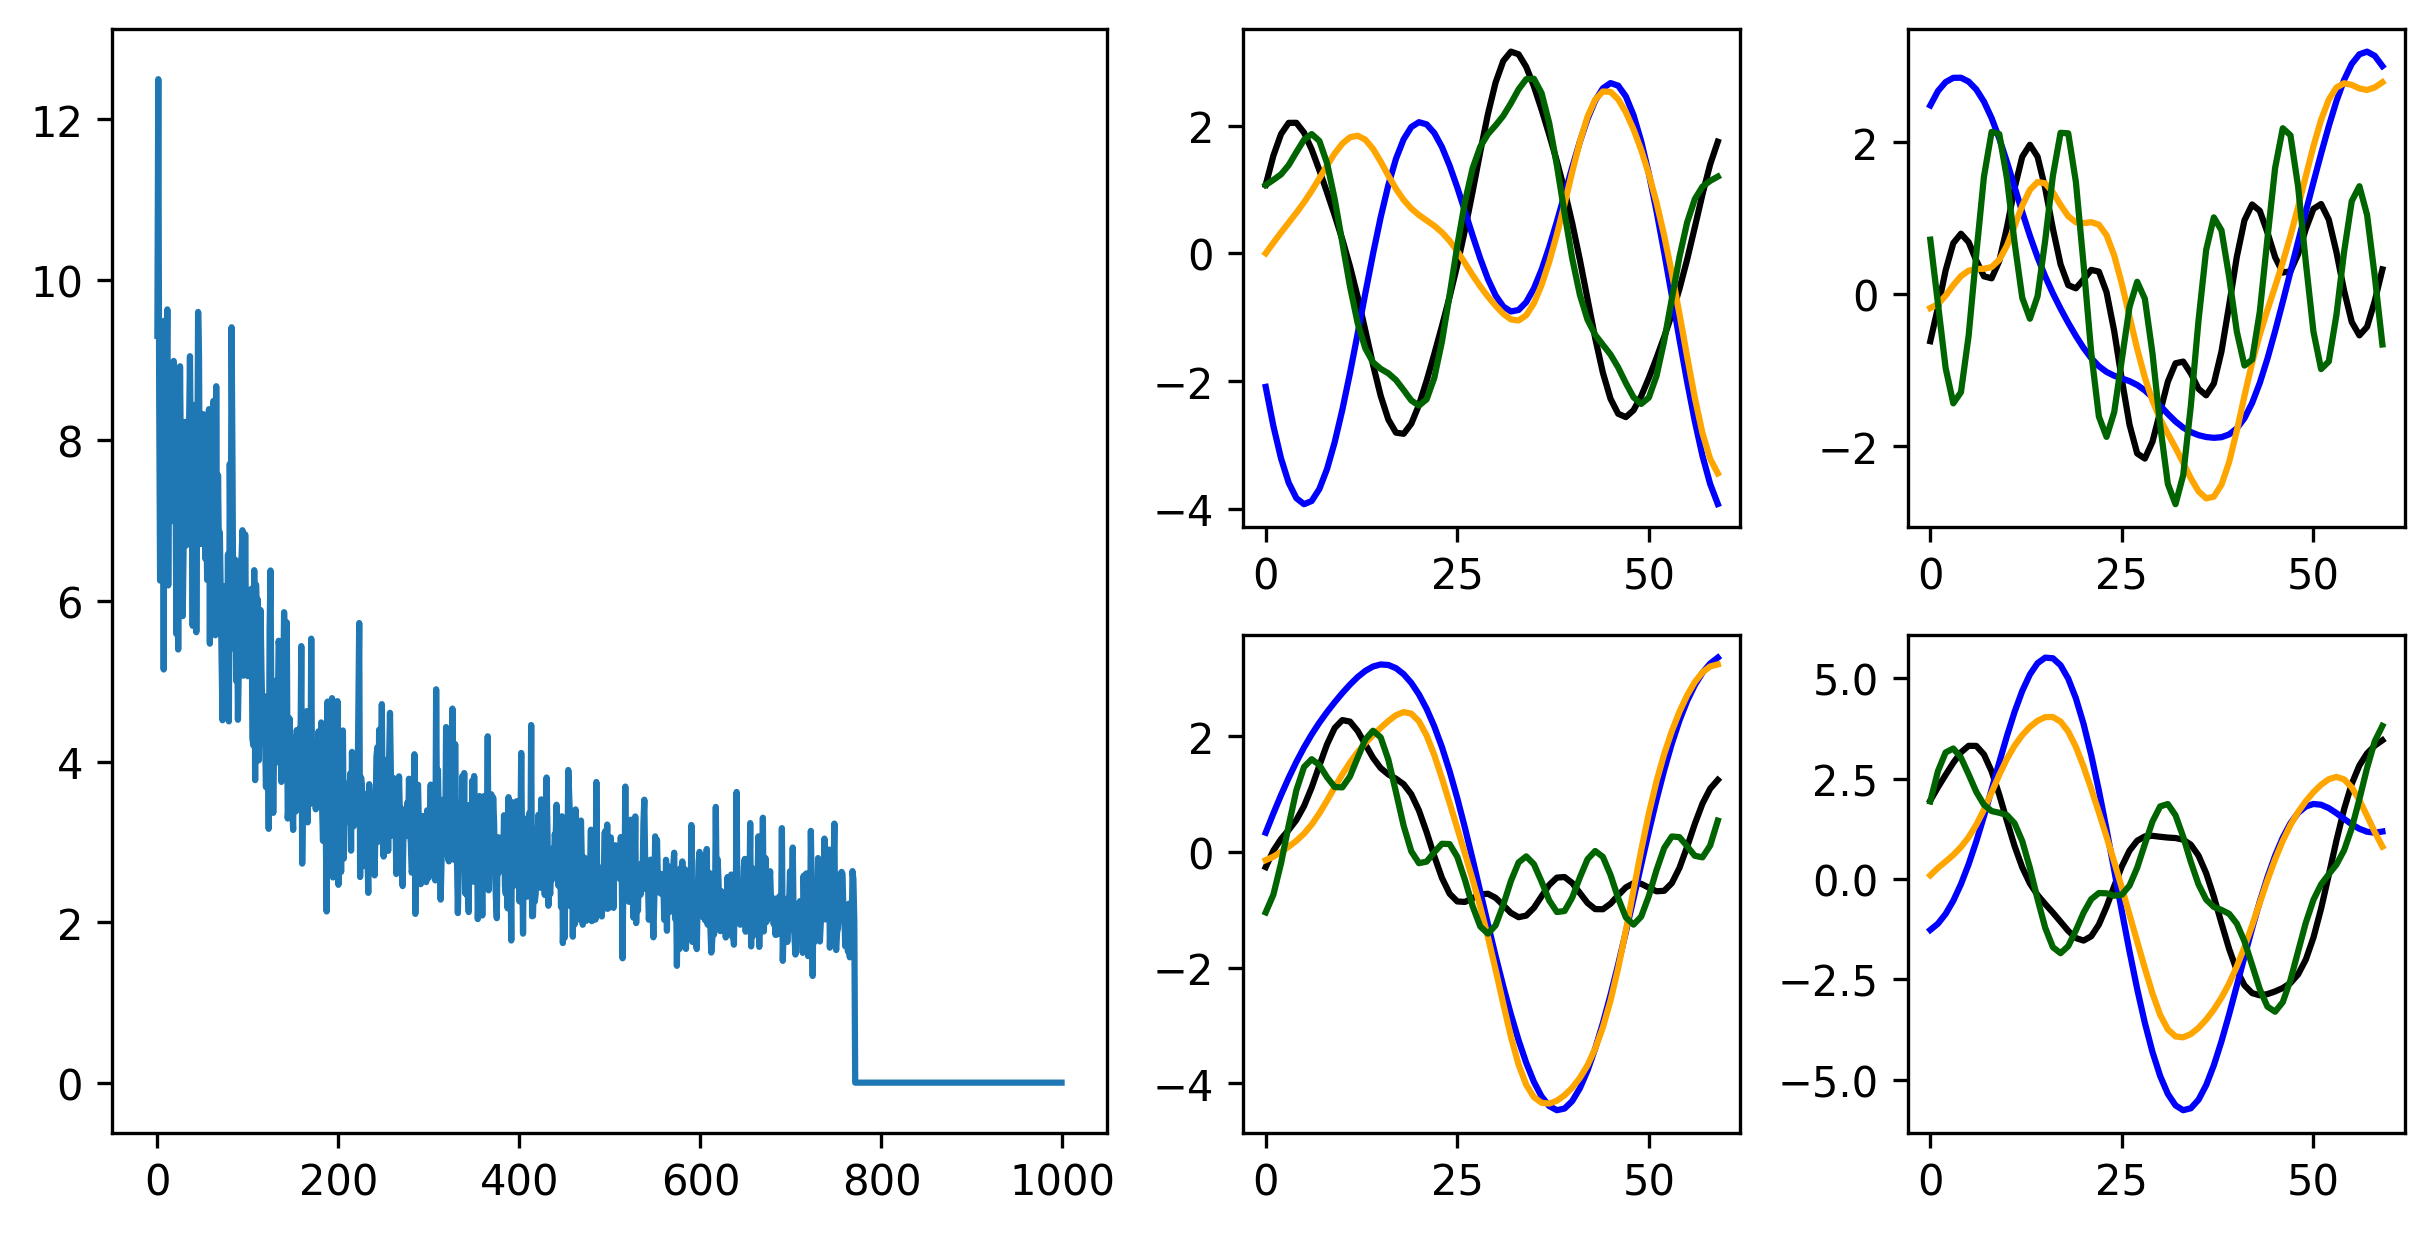

In [ ]:
training_steps=1000
batchsize=50
costs=np.zeros(training_steps)

skip_steps=10

# create one test trajectory, to compare against!
X0=np.random.randn(2,number_particles,4)
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
test_input=Xs[0,0,:,:][:,:,None] # will need shape [batchsize,timesteps,1]
test_correct_output=Xs[0,1,:,:][:,:,None] # shape [batchsize,timesteps,1]
test_particle2=Xs[0,2,:,:][:,:,None] # will need shape [batchsize,timesteps,1]


for j in range(training_steps):
    X0=np.random.randn(2,number_particles,batchsize)
    Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
    costs[j]=Net.train_on_batch(Xs[0,0,:,:][:,:,None],Xs[0,1,:,:][:,:,None]) 
    # needs input and output of shape [batchsize,timesteps,1]
    if j%skip_steps==0 or j==training_steps-1:
        clear_output(wait=True)
        fig=plt.figure(constrained_layout=True,figsize=(8,4))
        gs=fig.add_gridspec(ncols=4,nrows=2)
        cost_plot=fig.add_subplot(gs[0:2,0:2])
        cost_plot.plot(costs)
        test_output=Net.predict_on_batch(test_input)
        for n in range(4):
            theplot=fig.add_subplot(gs[n%2,2+int(n/2)])
            theplot.plot(test_input[n,:,0],color="black") # particle 0
            theplot.plot(test_correct_output[n,:,0],color="blue") # particle 1
            theplot.plot(test_output[n,:,0],color="orange") # NN-predicted particle 1
            theplot.plot(test_particle2[n,:,0],color="lightsteelblue") # particle 2
        plt.show()
    if False:
        if j%skip_steps==0:
            print(j, ":", costs[j],end="       \r")